# The Neural Tangent Kernel


## Notebook configuration
---
Configure general notebook configuration settings.

In [ ]:
# Disable some warnings
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Manage running directories
import os

SOURCE_PATH = './src'
EXPERIMENTS_PATH = './experiments'
GIFS_PATH = f'{EXPERIMENTS_PATH}/gifs'
IMAGES_PATH = f'{EXPERIMENTS_PATH}/images'
MODELS_PATH = f'{EXPERIMENTS_PATH}/models'
# Check if directories exist, if not create them
if not os.path.exists(SOURCE_PATH): os.mkdir(SOURCE_PATH)
if not os.path.exists(EXPERIMENTS_PATH): os.mkdir(EXPERIMENTS_PATH)
if not os.path.exists(GIFS_PATH): os.mkdir(GIFS_PATH)
if not os.path.exists(IMAGES_PATH): os.mkdir(IMAGES_PATH)
if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

# Manage python package imports paths
import sys

sys.path.insert(1, SOURCE_PATH)

### Google Colab

In [ ]:
%%capture

!pip install pytorch-utils

Uncoment the following lines if working with `Google Drive` cloud storage.

In [ ]:
# # Load the Drive helper and mount (uncoment lines)
# from google.colab import drive
# drive.mount('/content/drive')

# # Append mounted drive desired directory to python path
# DRIVE_NTK_PATH = 'drive/MyDrive/CBI'
# sys.path.insert(1, DRIVE_NTK_PATH)

Mounted at /content/drive


## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn, optim

import math
import imageio
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from types import SimpleNamespace

# Auxiliary functions
from utils import MLP, GradientDescent, NTK

# Visualization libraries
import matplotlib.pyplot as plt
from pytorch_utils.nb_figure import NBFigure

%matplotlib inline
plt.style.use('seaborn-whitegrid')

## Notebook Parameters
---

Specify the device that will be used for the computations. If available, it will use the GPU by default. If not, it will attempt to use the CPU.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Models are being executed in {device}')

Models are being executed in cuda:0


In [ ]:
# Init the linear space
linspace = torch.linspace(-5, 5, 1000).unsqueeze(1).to(device)
linspace_cpu = linspace.detach().cpu().numpy()

## Random Initializations
---

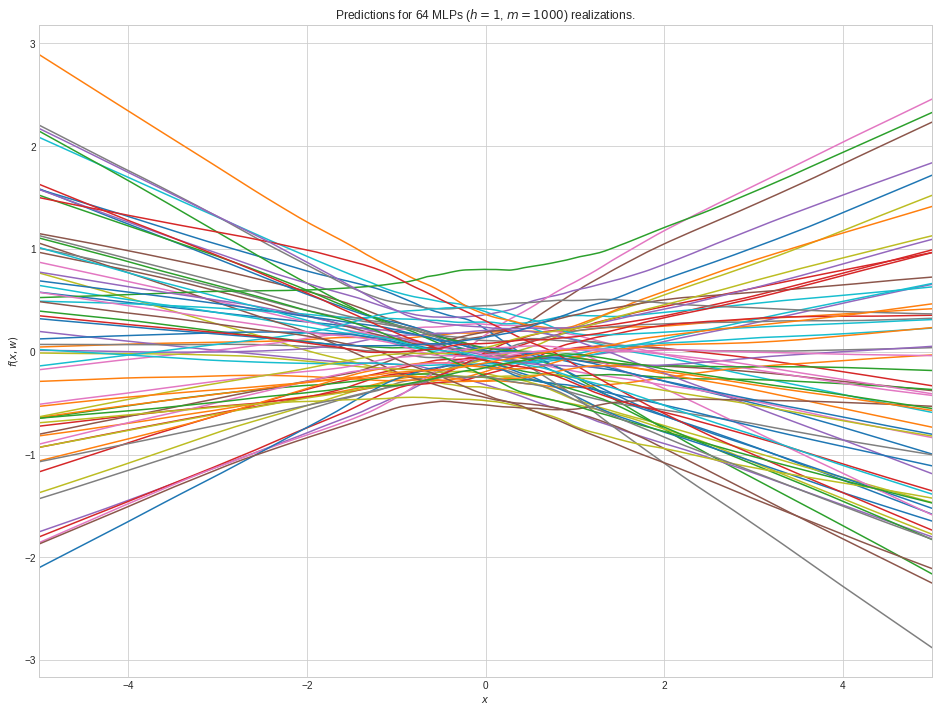

In [ ]:
N_NETWORKS = 64

prova = []

# Simple mlp parameters
mlp_params = SimpleNamespace(
    input_size=1,
    output_size=1,
    hidden_size=1000,
    hidden_layers=1,
    bias=True,
    zero_output=False,
    alpha=None,
)

plt.figure(figsize=(16, 12))

for i in range(N_NETWORKS):
    model = MLP(
        input_size=mlp_params.input_size,
        output_size=mlp_params.output_size,
        hidden_size=mlp_params.hidden_size,
        hidden_layers=mlp_params.hidden_layers,
        bias=mlp_params.bias,
        zero_output=mlp_params.zero_output,
        alpha=mlp_params.alpha
    ).to(device)
    # Forward input to the model
    out = model(linspace).detach().cpu().numpy()
    prova.append(out)
    # Plot model outputs
    plt.plot(linspace_cpu, out)

# Plot parameters
plt.title(
    f'Predictions for {N_NETWORKS} MLPs ($h = {mlp_params.hidden_layers}$, ' +
    f'$m = {mlp_params.hidden_size}$) realizations.')
plt.xlabel('$x$')
plt.ylabel('$f(x, w)$')
plt.xlim(-5, 5)
plt.savefig(
    f'{IMAGES_PATH}/Inits_NNets{N_NETWORKS}_' + 
    f'NLayers{mlp_params.hidden_layers}_Width{mlp_params.hidden_size}.png')
plt.show()

## Training with Gradient Descent
---

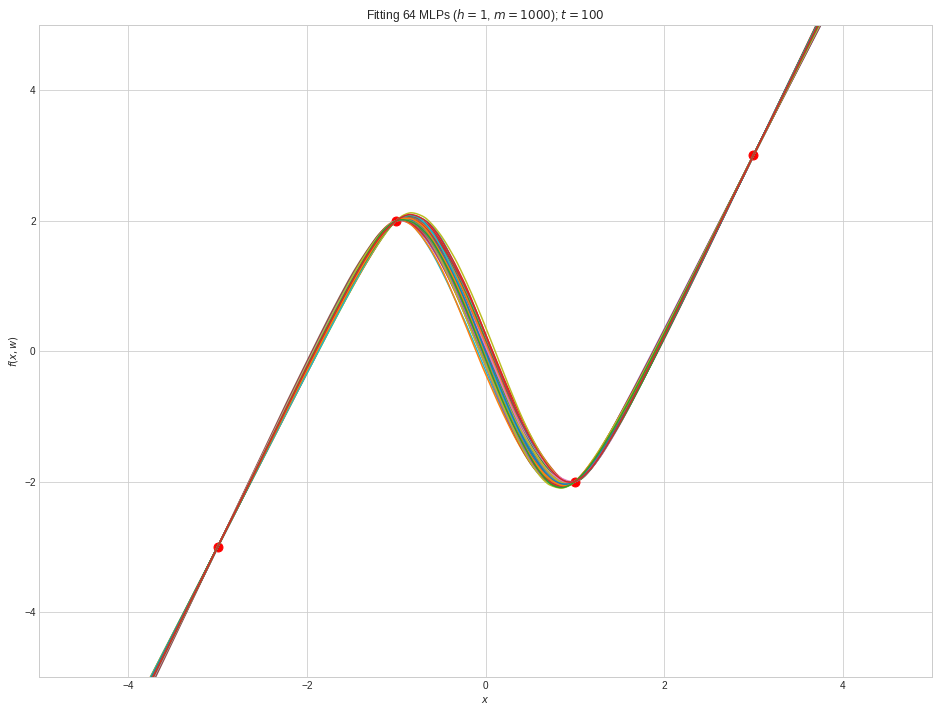

In [ ]:
# Hyper-parameters of the simulation
N_NETWORKS = 64
N_RUNS = 100
STEPS_PER_ITER = 10

# Simple mlp parameters
mlp_params = SimpleNamespace(
    input_size=1,
    output_size=1,
    hidden_size=1000,
    hidden_layers=1,
    bias=True,
    zero_output=False,
    alpha=None,
)

# Init all the networks
all_nets = [
    MLP(
        input_size=mlp_params.input_size,
        output_size=mlp_params.output_size,
        hidden_size=mlp_params.hidden_size,
        hidden_layers=mlp_params.hidden_layers,
        bias=mlp_params.bias,
        zero_output=mlp_params.zero_output,
        alpha=mlp_params.alpha
    ).to(device) for _ in range(N_NETWORKS)
]

###
# Points for fitting the neural networks
x = torch.tensor([-3, -1, 1, 3], dtype=torch.float).unsqueeze(1).to(device)
x_cpu = x.detach().cpu().numpy()
y = torch.tensor([-3, 2, -2, 3], dtype=torch.float).unsqueeze(1).to(device)
y_cpu = y.detach().cpu().numpy()


###
# Init the NBFigure
nbf = NBFigure('train_fig.png', figsize=(16, 12))
ax = nbf.getAxis()
# Setup some plotting parameters
ax.scatter(x_cpu, y_cpu, color='red', s=80)
ax.set_title(
    f'Fitting {N_NETWORKS} MLPs ($h = {mlp_params.hidden_layers}$, ' +
    f'$m = {mlp_params.hidden_size}$); $t = {0}$')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x, w)$')
nbf.set_xlim((-5, 5))
nbf.set_ylim((-5, 5))
nbf.display()
nbf.update()

# Plotting lines
lines, images = [], []

###
# First model outputs setup (no training being performed)
for net in all_nets:
    out = net(linspace).detach().cpu().numpy()
    l, = ax.plot(linspace_cpu, out)
    lines.append(l)
# Update graph
nbf.update()
# Save the first image for gif compounding
im0 = imageio.imread('train_fig.png')

###
# Fitting to data points
for i in tqdm(range(N_RUNS)):
    for line, net in zip(lines, all_nets):
        GradientDescent(net, x, y, iters=STEPS_PER_ITER)
        out = net(linspace).detach().cpu().numpy()
        line.set_data(linspace_cpu, out)
    ax.set_title(
        f'Fitting {N_NETWORKS} MLPs ($h = {mlp_params.hidden_layers}$, ' +
        f'$m = {mlp_params.hidden_size}$); $t = {i + 1}$')
    nbf.update()
    images.append(imageio.imread('train_fig.png'))

###
# Save the gif of the training procedure
images = [im0] * 5 + list(images)
images = np.array(images)
imageio.mimwrite(
    f'{GIFS_PATH}/Fitting_NNets{N_NETWORKS}_NPoints{x_cpu.shape[0]}_' +
    f'NLayers{mlp_params.hidden_layers}_Width{mlp_params.hidden_size}.gif',
    images, duration=0.1
)

## Weight Norm Change

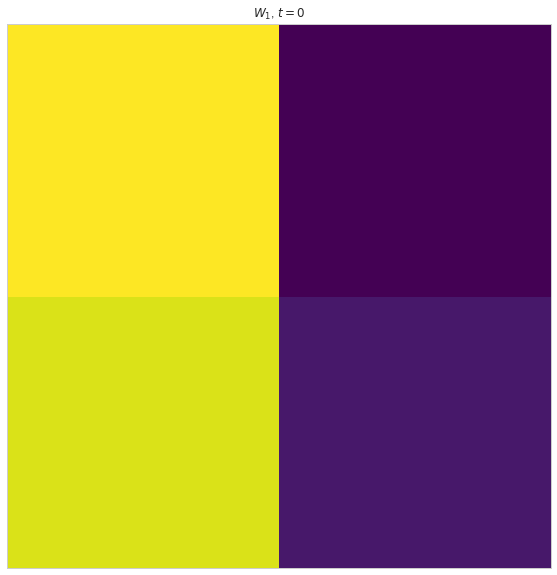

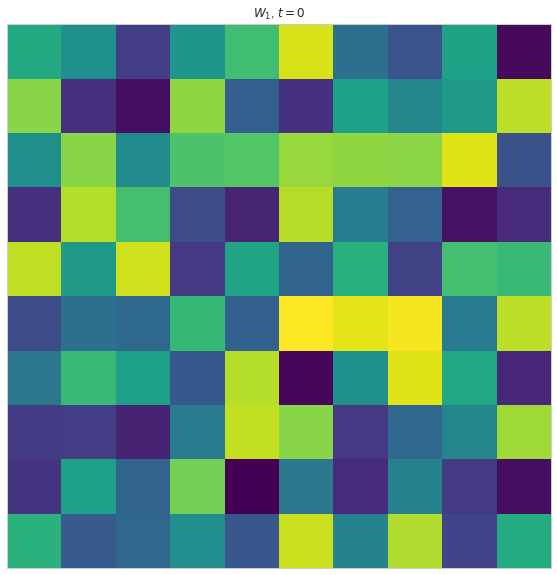

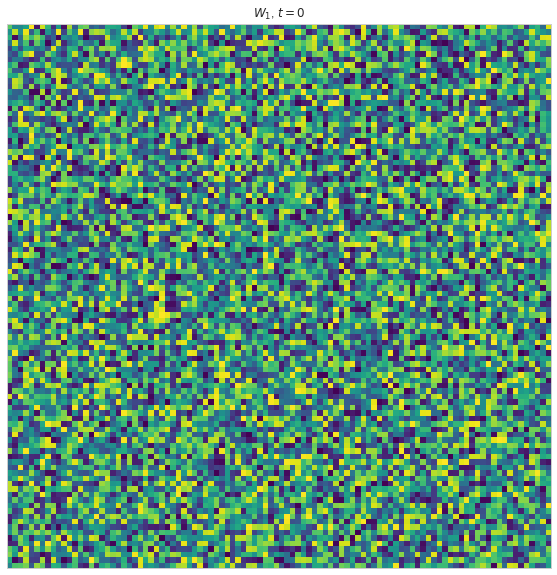

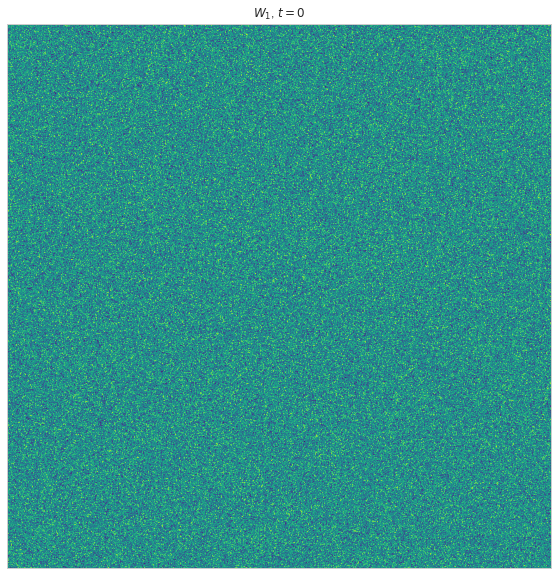

In [ ]:
ITERS = 1000
STEPS_PER_ITER = 1
EPS = 1E-03
# Specify if input/output layer projections are wanted
INPUT_OUTPUT_LAYERS = False
GIF = False

# Simple mlp parameters
mlp_params = SimpleNamespace(
    input_size=1,
    output_size=1,
    hidden_size=[2, 10, 100, 1000],
    hidden_layers=1 + 1,
    bias=True,
    zero_output=False,
    alpha=None,
)

###
# Points for fitting the neural networks
x = torch.tensor([-3, -1, 1, 3], dtype=torch.float).unsqueeze(1).to(device)
x_cpu = x.detach().cpu().numpy()
y = torch.tensor([-3, 2, -2, 3], dtype=torch.float).unsqueeze(1).to(device)
y_cpu = y.detach().cpu().numpy()


###
# Variable storing the end results
x_linspace_, norm_updates_, losses_ = {}, {}, {}

# Fitting the networks
for m in mlp_params.hidden_size:
    model = MLP(
        input_size=mlp_params.input_size,
        output_size=mlp_params.output_size,
        hidden_size=m,
        hidden_layers=mlp_params.hidden_layers,
        bias=mlp_params.bias,
        zero_output=mlp_params.zero_output,
        alpha=mlp_params.alpha
    ).to(device)
    # Create nbf figure with the specified parameters
    images_ = []
    offset = 1 if INPUT_OUTPUT_LAYERS else 3
    total_plots = \
        mlp_params.hidden_layers + 1 \
        if INPUT_OUTPUT_LAYERS else mlp_params.hidden_layers - 1
    nrows = max(1, int(total_plots / 2))
    ncols = math.ceil(total_plots / nrows)
    nbf = NBFigure(
        'weight_norm_change.png', figsize=(10 * ncols, 10 * nrows),
         nrows=nrows, ncols=ncols
    )
    ax = [nbf.getAxis(axis_num=i) for i in range(total_plots)]
    nbf.display()
    nbf.update()
    # Compute tangent kernel of the network
    #features, ntk = NTK(model, x)
    # Initial weights
    weights_hidden0 = [
        list(model.modules())[offset + i].weight.detach().cpu().numpy().copy()
        for i in range(0, total_plots * 2, 2)
    ]
    all_weights0 = \
        nn.utils.parameters_to_vector(
            model.parameters()).detach().cpu().numpy().copy()
    # Update graph
    images = []
    for i in range(total_plots):
        images.append(ax[i].imshow(weights_hidden0[i], cmap='viridis'))
        ax[i].set_title(f'$W_{i if offset == 1 else i + 1}$, $t = 0$')
        ax[i].grid(None)
        ax[i].axes.xaxis.set_ticks([])
        ax[i].axes.yaxis.set_ticks([])
    nbf.update()
    # Perform training
    images = [images]
    x_linspace = [0]
    norm_updates = [0]
    losses = []
    # Training for the specified points
    for i in tqdm(range(ITERS)):
        loss = GradientDescent(model, x, y, iters=STEPS_PER_ITER)
        losses.extend(loss)
        # Weights after training update
        weights_hidden = [
            list(model.modules())[offset + j].weight.detach().cpu().numpy().copy()
            for j in range(0, total_plots * 2, 2)
        ]
        all_weights = \
            nn.utils.parameters_to_vector(
                model.parameters()).detach().cpu().numpy().copy()
        # Compute normalized norm update
        norm_update = \
            np.linalg.norm(all_weights - all_weights0) \
            / np.linalg.norm(all_weights0)
        norm_updates.append(norm_update)
        x_linspace.append((i + 1) * STEPS_PER_ITER)
        # Update graph
        if GIF:
            for j in range(total_plots):
                images[-1][j].set_data(weights_hidden[j])
                ax[j].set_title(f'$W_{j if offset == 1 else j + 1}$, $t = {i}$')
            nbf.update()
            images_.append(imageio.imread('weight_norm_change.png'))
        # Additional stopping condition
        if loss[-1] < EPS: break
    
    # Save results
    x_linspace_[m] = x_linspace
    norm_updates_[m] = norm_updates
    losses_[m] = losses
    # Save to png
    if GIF:
        gifname = \
            f'{GIFS_PATH}/WeightUpdates_NPoints{x_cpu.shape[0]}_' + \
            f'NLayers{mlp_params.hidden_layers}_Width{m}_' + \
            f'{"No" if not INPUT_OUTPUT_LAYERS else ""}InpOutLayers.gif'
        imageio.mimwrite(gifname, images_, duration=0.001)

**Relative change in norm of weights from initialization**

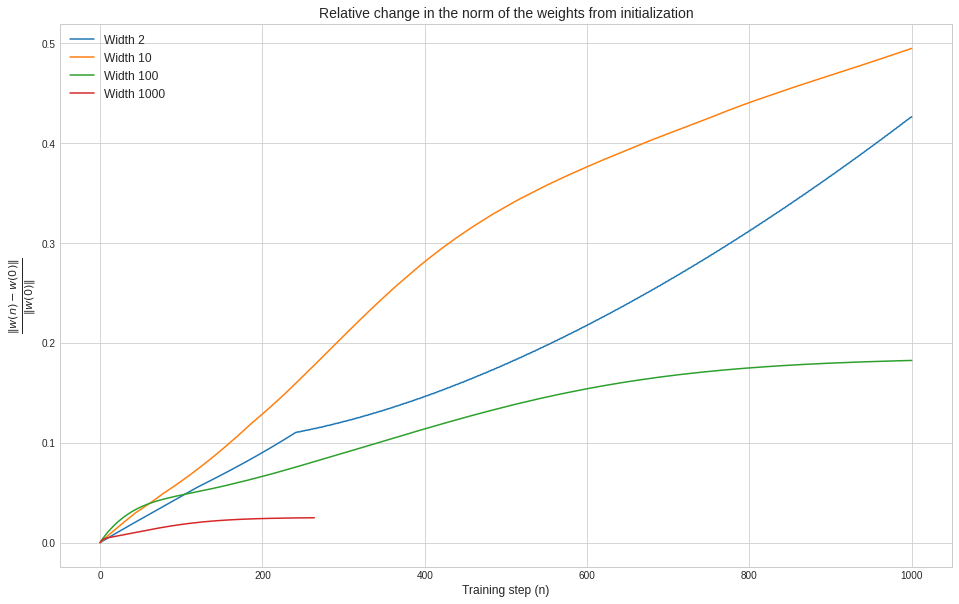

In [ ]:
plt.figure(figsize=(16, 10))

for m in sorted(x_linspace_.keys()):
    plt.plot(x_linspace_[m], norm_updates_[m], label=f'Width {m}')

plt.title(
    'Relative change in the norm of the weights from initialization',
    fontsize=14
)
plt.xlabel('Training step (n)', fontsize=12)
plt.ylabel(r'$\frac{\Vert w(n) - w(0) \Vert}{\Vert w(0) \Vert}$', fontsize=16)
plt.legend(prop={'size': 12})
plt.savefig(
    f'{IMAGES_PATH}/WeightNormChange_NLayers{mlp_params.hidden_layers}_' + 
    f'Width{"-".join([str(m) for m in mlp_params.hidden_size])}.png')
plt.show()

**Training Loss**

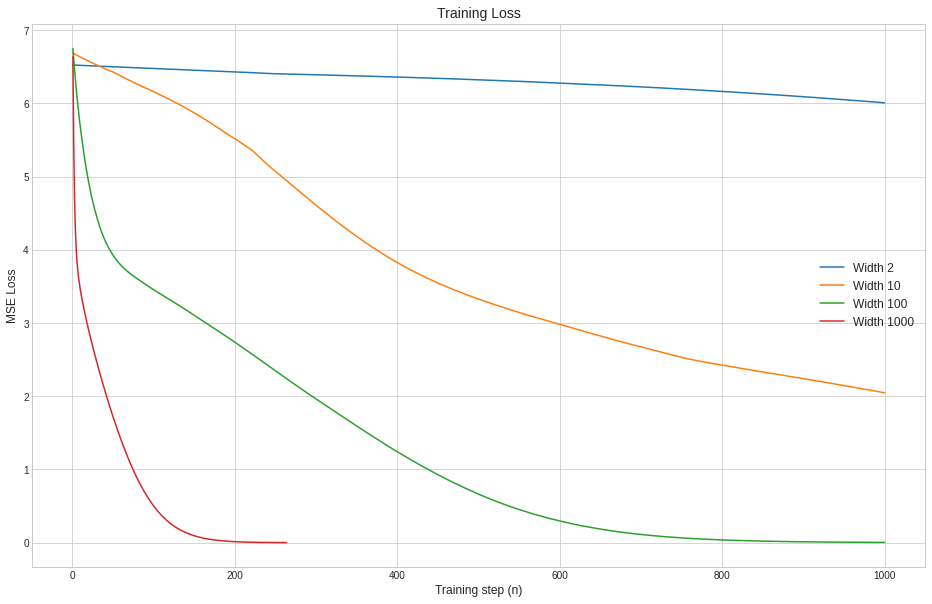

In [ ]:
plt.figure(figsize=(16, 10))

for m in sorted(x_linspace_.keys()):
    plt.plot(x_linspace_[m][1:], losses_[m], label=f'Width {m}')

plt.title(
    'Training Loss', fontsize=14
)
plt.xlabel('Training step (n)', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend(prop={'size': 12})
plt.savefig(
    f'{IMAGES_PATH}/TrainLoss_NLayers{mlp_params.hidden_layers}_' + 
    f'Width{"-".join([str(m) for m in mlp_params.hidden_size])}.png')
plt.show()

## Scaling parameter $\alpha$

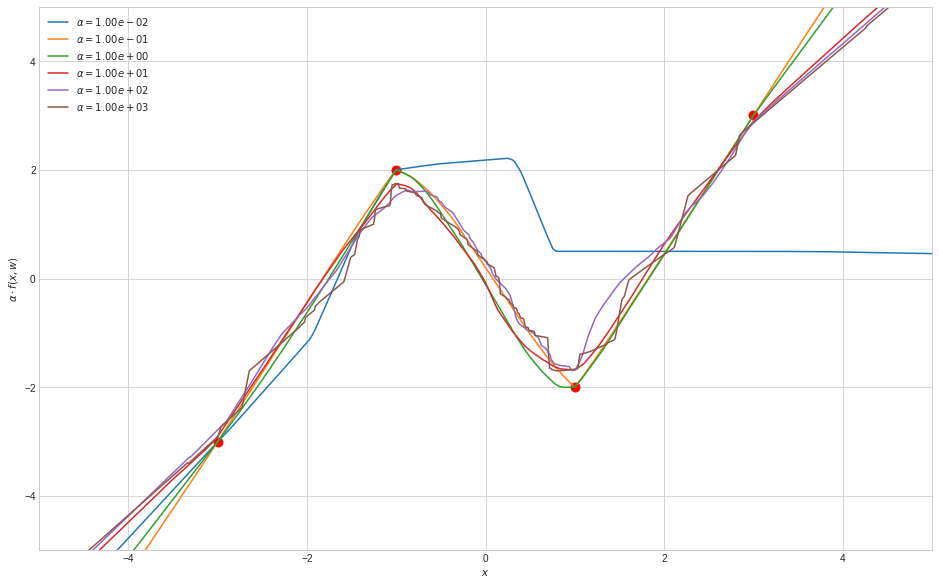

In [ ]:
# Hyper-parameters of the simulation
N_RUNS = 1
STEPS_PER_ITER = 4000

# Simple mlp parameters
mlp_params = SimpleNamespace(
    input_size=1,
    output_size=1,
    hidden_size=100,
    hidden_layers=2,
    bias=True,
    zero_output=True,
    alpha=10**torch.linspace(-2, 3, 6),
)

###
# Points for fitting the neural networks
x = torch.tensor([-3, -1, 1, 3], dtype=torch.float).unsqueeze(1).to(device)
x_cpu = x.detach().cpu().numpy()
y = torch.tensor([-3, 2, -2, 3], dtype=torch.float).unsqueeze(1).to(device)
y_cpu = y.detach().cpu().numpy()

plt.figure(figsize=(16, 10))
relative_changes_ = []
# For the different scaling factors
for a in tqdm(mlp_params.alpha):
    # Compute over N_RUNS and average results
    relative_changes = []
    for i in range(N_RUNS):
        # Init the model
        model = MLP(
            input_size=mlp_params.input_size,
            output_size=mlp_params.output_size,
            hidden_size=mlp_params.hidden_size,
            hidden_layers=mlp_params.hidden_layers,
            bias=mlp_params.bias,
            zero_output=mlp_params.zero_output,
            alpha=a
        ).to(device)
        # Jacobian and tangent kernel at initialization
        jac0, ntk0 = NTK(model, x, device=device)
        jac0 = jac0.detach().cpu().numpy()
        ntk0 = ntk0.detach().cpu().numpy()
        # Perform fitting with regular gradient descent
        GradientDescent(model, x, y, iters=STEPS_PER_ITER, alpha=a, lr=3e-04)
        # Jacobian and tangent kernel after training
        jac1, ntk1 = NTK(model, x, device=device)
        jac1 = jac1.detach().cpu().numpy()
        ntk1 = ntk1.detach().cpu().numpy()
        # Compute output of the model
        out = model(linspace).detach().cpu().numpy()
        # Compute relative change in the tangent kernel norm
        relative_changes.append(
            np.linalg.norm(ntk1 - ntk0) / np.linalg.norm(ntk0))
    # Update variables and plot
    relative_changes_.append(sum(relative_changes) / N_RUNS)
    plt.plot(linspace_cpu, out, label=fr'$\alpha = {a:.2e}$')

plt.scatter(x_cpu, y_cpu, color='red', s=80)
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel(r'$x$')
plt.ylabel(r'$\alpha \cdot f(x, w)$')
plt.legend()
plt.show()

**NTK relative change with scaling parameter $\alpha$**

In [ ]:
relative_changes_ = pd.DataFrame({
    'Alpha': [f'{a:.2e}' for a in mlp_params.alpha],
    'Relative Change': relative_changes_
})

relative_changes_

,Alpha,Relative Change
0,1.00e-02,2.179154e+01
1,1.00e-01,1.434274e+00
2,1.00e+00,4.366491e-02
3,1.00e+01,4.519317e-04
4,1.00e+02,6.921638e-06
5,1.00e+03,5.403731e-08


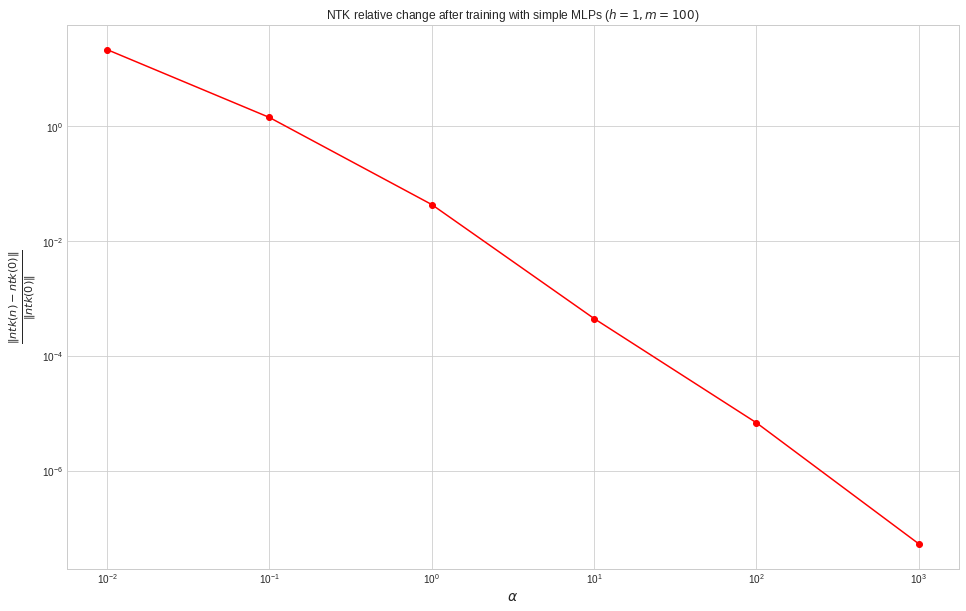

In [ ]:
plt.figure(figsize=(16, 10))

plt.loglog(
    mlp_params.alpha, relative_changes_['Relative Change'],
    color='red', marker='o'
)
plt.title(
    f'NTK relative change after training with simple MLPs ' + \
    f'($h = {mlp_params.hidden_layers}, m = {mlp_params.hidden_size}$)'
)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(
    r'$\frac{\Vert ntk(n) - ntk(0) \Vert}{\Vert ntk(0) \Vert}$', fontsize=16)
plt.show()